In [8]:
from sentence_transformers import SentenceTransformer

In [31]:
sentence_model = SentenceTransformer("google/electra-small-discriminator")

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.21k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/54.2M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/google_electra-small-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups(subset='all')['data']

In [32]:
embeddings = sentence_model.encode(data, show_progress_bar=True)

Batches:   0%|          | 0/589 [00:00<?, ?it/s]

In [13]:
embeddings

array([[-0.3415643 , -0.03037549, -0.34910348, ...,  0.70665795,
        -0.5806842 ,  0.4242857 ],
       [-0.23130767, -0.14745522, -0.23816738, ...,  0.9410861 ,
        -0.50692654,  0.53153276],
       [-0.2246227 , -0.09965092, -0.11854216, ...,  0.8495635 ,
        -0.48628664,  0.6825721 ],
       ...,
       [-0.27898976, -0.05158854, -0.12057273, ...,  0.7650437 ,
        -0.5143403 ,  0.48991963],
       [-0.2325651 , -0.03798837, -0.38894337, ...,  0.83175826,
        -0.4934479 ,  0.6241261 ],
       [-0.08853108,  0.14157063, -0.15425311, ...,  0.6423447 ,
        -0.29999855,  0.5532598 ]], dtype=float32)

In [33]:
import umap.umap_ as umap
umap_embeddings = umap.UMAP(n_neighbors=25, 
                            n_components=8).fit_transform(embeddings)

In [34]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=25,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

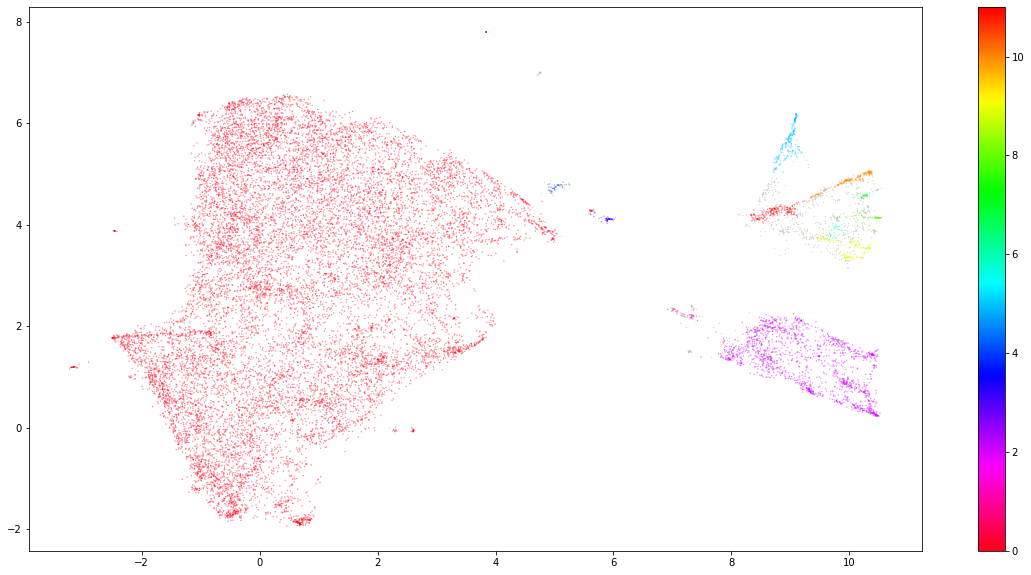

In [35]:
import matplotlib.pyplot as plt
import pandas as pd


# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0).fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [36]:
result

,x,y,labels
0,-0.872043,-0.270361,0
1,2.958761,1.879252,0
2,8.760455,4.402609,-1
3,2.326772,5.032004,0
4,-0.901285,0.657177,0
...,...,...,...
18841,0.848208,5.838382,0
18842,9.932622,1.477228,2
18843,-0.301792,-0.131380,0
18844,8.921073,1.927718,2


In [37]:
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [38]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

In [39]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df)
topic_sizes.head(10)

,Topic,Size
1,0,15481
3,2,1542
0,-1,870
6,5,211
11,10,181
12,11,172
10,9,155
9,8,61
4,3,47
7,6,35


In [48]:
import itertools
import numpy as np
from typing import List

import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [51]:
topic_sizes['Topic'].tolist()

[0, 2, -1, 5, 10, 11, 9, 8, 3, 6, 1, 4, 7]

In [52]:
subplot_titles = topic_sizes['Topic'].tolist()

In [84]:
topic_sizes

,Topic,Size
1,0,15481
3,2,1542
0,-1,870
6,5,211
11,10,181
12,11,172
10,9,155
9,8,61
4,3,47
7,6,35


In [99]:
def plts(topics: List[int] = None,
                       top_n_topics: int = 8,
                       n_words: int = 5,
                       width: int = 250,
                       height: int = 250) -> go.Figure:
    
    colors = itertools.cycle(["#D55E00", "#0072B2", "#CC79A7", "#E69F00", "#56B4E9", "#009E73", "#F0E442"])
    columns = 4
    rows = 4

    width = 250
    height = 250 
    
    # Initialize figure
    subplot_titles = topic_sizes['Topic'].tolist()
    fig = make_subplots(rows=4,
                    cols=4,
                    shared_xaxes=False,
                    horizontal_spacing=.1,
                    vertical_spacing=.4 / rows if rows > 1 else 0,
                    subplot_titles=subplot_titles)

    # Add barchart for each topic
    row = 1
    column = 1
    for topic in top_n_words:
        words = [word for word,_ in top_n_words[topic]]
        scores = [score for _,score in top_n_words[topic]]

        fig.add_trace(
        go.Bar(x=scores,
               y=words,
               orientation='h',
               marker_color=next(colors)),
        row=row, col=column)

        if column == columns:
            column = 1
            row += 1
        else:
            column += 1

    # Stylize graph
    fig.update_layout(
        template="plotly_white",
        showlegend=False,
        title={
            'text': "<b>Topic Word Scores",
            'x': .5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(
                size=22,
                color="Black")
        },
        width=width*4,
        height=height*rows if rows > 1 else height * 1.3,
        hoverlabel=dict(
            bgcolor="white",
            font_size=16,
            font_family="Rockwell"
        ),
    )

    fig.update_xaxes(showgrid=True)
    fig.update_yaxes(showgrid=True)


    return fig

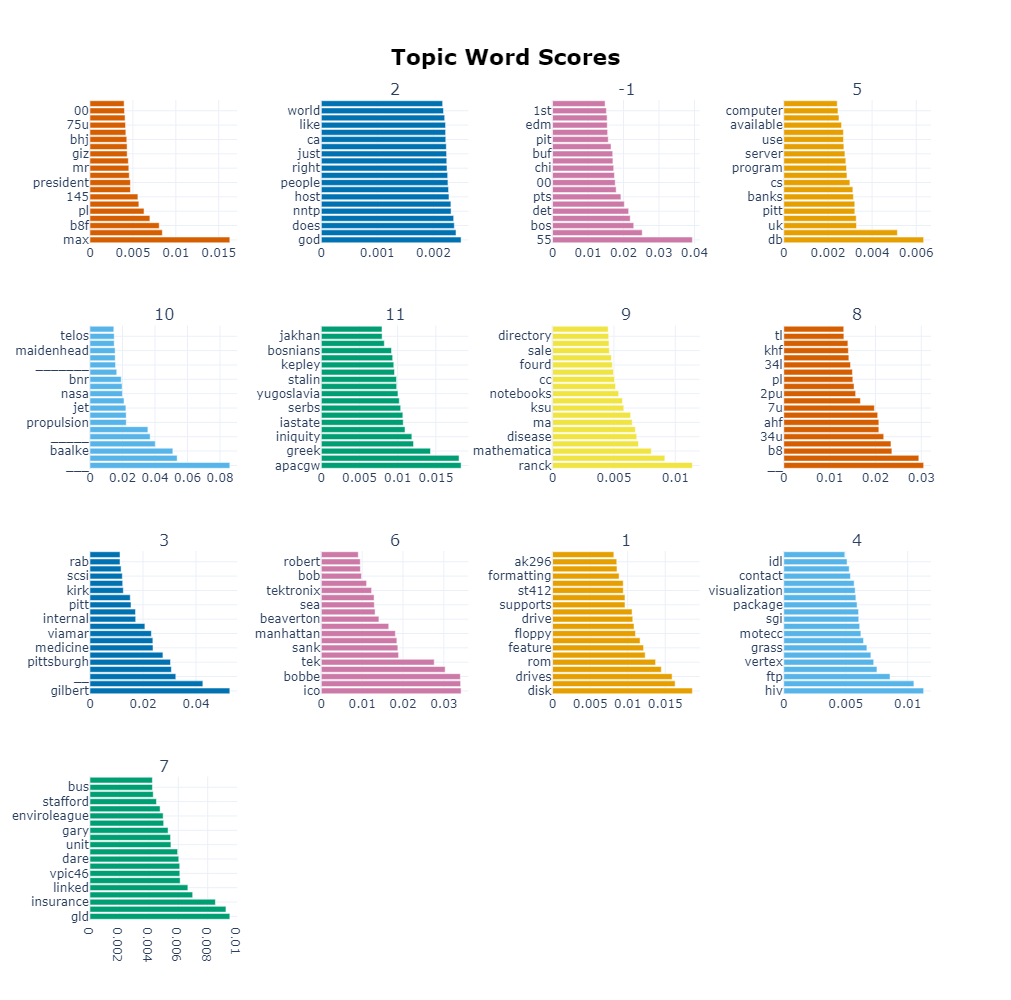

In [102]:
plts()

In [101]:
pip install kaleido

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
